In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers, regularizers, models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle, randint
import numpy as np
import future
from keras.applications import VGG16

import matplotlib.pyplot as plt
import os, shutil
from os import listdir
from os.path import join, isfile, exists
from keras.models import load_model, model_from_json

In [34]:
def make_dir_helper(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)
        return True
    return False

In [35]:
def delete_dir_helper(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
        return True
    return False

In [36]:
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])
    model.summary()

In [37]:
project_dir_name = join('Esri Project')
#project_dir_name = join('desktop','Esri Project')
original_dataset_dir = join(os.path.expanduser('~'), project_dir_name, 'original data');
base_dir =  join(os.path.expanduser('~'), project_dir_name, 'data');
base_scripts_dir =  join(os.path.expanduser('~'), project_dir_name, 'scripts');
model_dir =  join(os.path.expanduser('~'),  project_dir_name, 'models');

MODEL_FILE_NAME = 'map_multi_model_2.h5'
CLASSES_TO_CLASSIFY = ['Airplane', 'Beach', 'Buildings', 'Forest', 'Freeway', 'Parkinglot']
ext = '.jpg'
IMAGE_SIZE = 150
EPOCHS = 17
NO_TRAINING_SAMPLES = 70
BATCH_SIZE = 15
STEPS_PER_EPOCH = 5

train_dir = join(base_dir, 'train')
validation_dir = join(base_dir, 'validation')
test_dir = join(base_dir, 'test')
model_file_path = join(model_dir, MODEL_FILE_NAME)

# Delete the previous data folder and all its contents
delete_dir_helper(base_dir)

make_dir_helper(base_dir)
make_dir_helper(model_dir)

# Make base directories
make_dir_helper(train_dir)
make_dir_helper(validation_dir)
make_dir_helper(test_dir)

for classes in CLASSES_TO_CLASSIFY:
    
    train_class_dir = join(train_dir, classes)
    validation_class_dir = join(validation_dir, classes)
    test_class_dir = join(test_dir, classes)
    
    # Make train sub directories
    make_dir_helper(train_class_dir)
    make_dir_helper(validation_class_dir)
    make_dir_helper(test_class_dir)
    
    indexes = [i for i in range(100)]
    shuffle(indexes)
    train_indexes = indexes[:70]
    test_indexes = indexes[70:100]
    
    fnames = [(classes + '{}' + ext).format(i) for i in train_indexes]
    for fname in fnames:
        src_dir = join(original_dataset_dir, fname)
        dst_dir = join(train_class_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

    # Copy classes into the validation dataset
    fnames = [(classes + '{}' + ext).format(i) for i in test_indexes]
    for fname in fnames:
        src_dir = join(original_dataset_dir, fname)
        dst_dir = join(validation_class_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

    # Copy classes into the test dataset
    fnames = [(classes + '{}' + ext).format(i) for i in test_indexes]
    for fname in fnames:
        src_dir = join(original_dataset_dir, fname)
        dst_dir = join(test_class_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

In [38]:
is_model_from_file = False
model = None
if exists(model_file_path):
    print('Found saved model with name ' + MODEL_FILE_NAME)
    model = load_model(model_file_path)
    compile_model(model)
else:
    print('NO saved model with name ' + MODEL_FILE_NAME)

NO saved model with name map_multi_model_2.h5


In [39]:
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       vertical_flip=True,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       horizontal_flip=True)  
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
            train_dir,  
            target_size=(IMAGE_SIZE, IMAGE_SIZE),  
            batch_size=BATCH_SIZE,
            class_mode='categorical')  

    validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
            class_mode='categorical')

Found 420 images belonging to 6 classes.
Found 180 images belonging to 6 classes.


In [40]:
    for idx, (data_batch, labels_batch) in enumerate(train_generator):
        print('data batch:', data_batch.shape)
        print('labels batch:', labels_batch.shape)
        break

('data batch:', (15, 150, 150, 3))
('labels batch:', (15, 6))


In [41]:
#     model = models.Sequential()
#     model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
#     model.add(layers.MaxPooling2D((2, 2)))
#     model.add(conv_base)
#     model.add(layers.Flatten())
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dense(6, activation='softmax'))

In [42]:
    model = models.Sequential()
    conv_base = VGG16(weights='imagenet' ,include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    conv_base.trainable = False
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='sigmoid'))

In [43]:
    compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 16,813,638
Trainable params: 16,813,638
Non-trainable params: 0
_________________________________________________________________


Epoch 1/17
10/10 [==============================] - 13s - loss: 2.3499 - acc: 0.1733 - val_loss: 2.2193 - val_acc: 0.3533
Epoch 2/17
10/10 [==============================] - 13s - loss: 2.1808 - acc: 0.2267 - val_loss: 2.0459 - val_acc: 0.2400
Epoch 3/17
10/10 [==============================] - 14s - loss: 2.0932 - acc: 0.3400 - val_loss: 1.7765 - val_acc: 0.4933
Epoch 4/17
10/10 [==============================] - 13s - loss: 1.8957 - acc: 0.4200 - val_loss: 1.3715 - val_acc: 0.6733
Epoch 5/17
10/10 [==============================] - 12s - loss: 1.8083 - acc: 0.5200 - val_loss: 1.5101 - val_acc: 0.5133
Epoch 6/17
10/10 [==============================] - 13s - loss: 1.2771 - acc: 0.6200 - val_loss: 1.0147 - val_acc: 0.6667
Epoch 7/17
10/10 [==============================] - 13s - loss: 1.7381 - acc: 0.4933 - val_loss: 0.9707 - val_acc: 0.8267


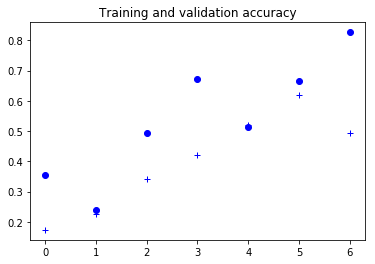

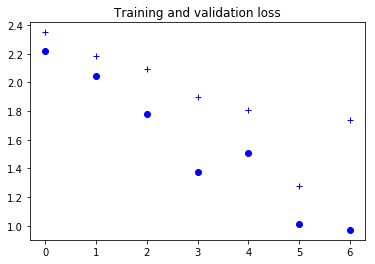

In [44]:
    callbacks = [
        EarlyStopping(monitor='acc', patience=0, mode='auto'),
        ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=model_file_path)
    ]
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks = callbacks,
        validation_steps=10)

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b+')
    plt.plot(epochs, val_acc, 'bo')
    plt.title('Training and validation accuracy')

    plt.figure()

    plt.plot(epochs, loss, 'b+')
    plt.plot(epochs, val_loss, 'bo')
    plt.title('Training and validation loss')

    plt.show()

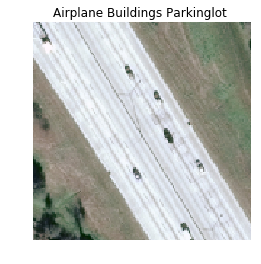

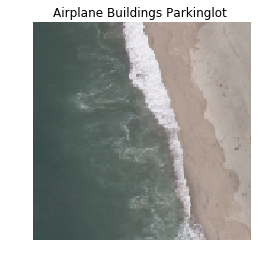

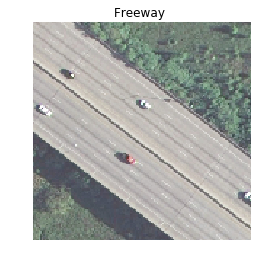

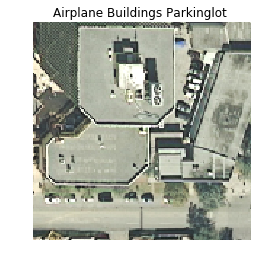

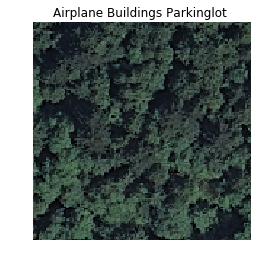

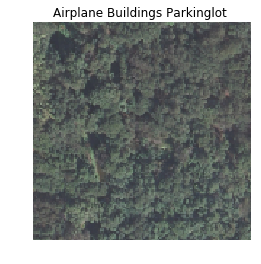

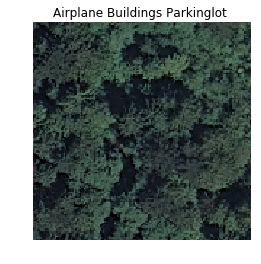

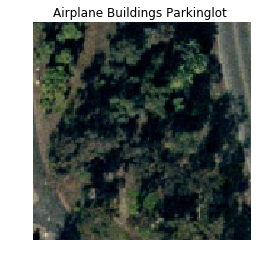

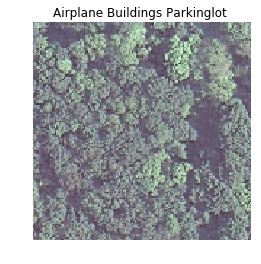

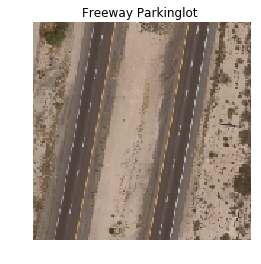

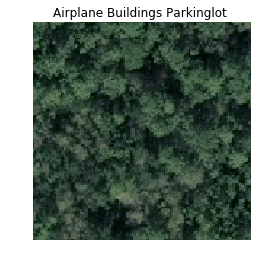

In [60]:
fnames = []
target_dir = test_dir
dnames = [os.path.join(target_dir, dname) for dname in os.listdir(target_dir)]
for dname in dnames:
    fnames.extend([os.path.join(dname, fname) for fname in os.listdir(dname)])

shuffle(fnames)

NO_OF_FIG = 10


for index, img_path in enumerate(fnames):
    
    img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    plt.figure(index)
    imgplot = plt.imshow(img)

    x = image.img_to_array(img)
    x = x.reshape((1,) + x.shape)
    prediction = model.predict(x)[0]
    # print(prediction)

    max_indexes = (np.argwhere(prediction == np.amax(prediction))).flatten()
    # print(max_indexes)
    
    title = ''
    
    for idx in max_indexes:
        if prediction[idx] == 1:
            title += CLASSES_TO_CLASSIFY[idx] + ' '
        else:
            title = 'Unknown'
    
    plt.axis('off')
    plt.title(title)
    
    if index >= NO_OF_FIG:
        break

plt.show()